# Hierarchical Agent Teams With RAG

In our previous example (Agent Supervisor), we introduced the concept of a single supervisor node to route work between different worker nodes.

But what if the job for a single worker becomes too complex? What if the number of workers becomes too large?

For some applications, the system may be more effective if work is distributed hierarchically.

You can do this by composing different subgraphs and creating a top-level supervisor, along with mid-level supervisors.

## Setup and Import Libraries

In [1]:
import os
from pathlib import Path
from tempfile import TemporaryDirectory
from typing import Dict, Optional, List, Literal, Annotated
from typing_extensions import TypedDict
from langchain_openai import OpenAIEmbeddings
from langchain.document_loaders import TextLoader, WebBaseLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.vectorstores import FAISS
from langchain.chat_models import init_chat_model
from langchain.agents import Tool
from langchain_core.messages import HumanMessage, trim_messages
from langchain_core.language_models.chat_models import BaseChatModel
from langchain_core.tools import tool
from langchain_tavily import TavilySearch
from langchain_experimental.utilities import PythonREPL
from langgraph.prebuilt import create_react_agent
from langgraph.graph import StateGraph, MessagesState, START, END
from langgraph.types import Command
from dotenv import load_dotenv

USER_AGENT environment variable not set, consider setting it to identify your requests.


In [2]:
load_dotenv()

True

In [3]:
os.environ["TAVILY_API_KEY"] = os.getenv("TAVILY_API_KEY")
os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")

In [4]:
embeddings = OpenAIEmbeddings()
llm = init_chat_model("openai:gpt-4o-mini")

## CREATE TOOLS

In [5]:
tavily_tool = TavilySearch(max_results=5)

In [6]:
@tool
def scrape_webpages(urls:List[str]) -> str:
    """ 
    Use Requests and BS4 to scrap the provided web pages for detailed information
    """
    documents = WebBaseLoader(urls).load()
    return "\n\n".join(
        [
            f"<Document name='{document.metadata.get("title", "")}'>\n{document.page_content}\n</Document>"
            for document in documents
        ]
    )

In [7]:
_TEMP_DIRECTORY = TemporaryDirectory()
WORKING_DIRECTORY = Path(_TEMP_DIRECTORY.name)

# Document Writer
@tool
def create_outline(
    points: Annotated[List[str], "List of main points or sections."],
    file_name: Annotated[str, "File path to save the outline."], 
) -> Annotated[str, "Path of the saved outline file."]:
    """
    Create and save an outline.
    """
    with (WORKING_DIRECTORY / file_name).open(mode="w") as file:
        for i, point in enumerate(points):
            file.write(f"{i + 1}. {point}\n")
    return f"Outline saved to {file_name}"


@tool
def write_document(
    content: Annotated[str, "Text content to be written into the document."],
    file_name: Annotated[str, "File path to save the document."],
) -> Annotated[str, "Path of the saved document file."]:
    """
    Create and save a text document.
    """
    with (WORKING_DIRECTORY / file_name).open(mode="w") as file:
        file.write(content)

    return f"Document saved to {file_name}"


@tool
def edit_document(
    file_name: Annotated[str, "Path of the document to be edited."],
    inserts: Annotated[
        Dict[int, str],
        "Dictionary where key is the line number (1-indexed) and value is the text to be inserted at that line.",
    ],
) -> Annotated[str, "Path of the edited document file."]:
    """Edit a document by inserting text at specific line numbers."""

    with (WORKING_DIRECTORY / file_name).open(mode="r") as file:
        lines = file.readlines()

    sorted_inserts = sorted(inserts.items())

    for line_number, text in sorted_inserts:
        if 1 <= line_number <= len(lines) + 1:
            lines.insert(line_number - 1, text + "\n")
        else:
            return f"Error: Line number {line_number} is out of range."

    with (WORKING_DIRECTORY / file_name).open(mode="w") as file:
        file.writelines(lines)

    return f"Document edited and saved to {file_name}"

@tool
def read_document(
    file_name: Annotated[str, "File path to read the document from."],
    start: Annotated[Optional[int], "The start line. Default is 0"] = None,
    end: Annotated[Optional[int], "The end line. Default is None"] = None,
) -> str:
    """Read the specified document."""
    with (WORKING_DIRECTORY / file_name).open("r") as file:
        lines = file.readlines()
    if start is None:
        start = 0
    return "\n".join(lines[start:end])

In [8]:
# WORKING_DIRECTORY

### Chart Generator Tool

In [9]:
repl = PythonREPL()


@tool
def python_repl_tool(
    code: Annotated[str, "The python code to execute to generate your chart."],
):
    """Use this to execute python code. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user."""
    try:
        result = repl.run(code)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    return f"Successfully executed:\n```python\n{code}\n```\nStdout: {result}"

### Create Retriver Tool

In [10]:
def make_retriever_tool_from_text(file, name, description, chunk_size=500, chunk_overlap=50):
    documents = TextLoader(file_path=file, encoding="utf-8").load()
    chunks = RecursiveCharacterTextSplitter(
        chunk_size=chunk_size, chunk_overlap=chunk_overlap).split_documents(documents=documents)
    
    vector_store = FAISS.from_documents(
        documents=chunks, 
        embedding=embeddings
    )

    retriever = vector_store.as_retriever()

    def tool_function(query:str) -> str:
        print(f"📚 Using Tool: {name}")
        results = retriever.invoke(input=query)
        return "\n\n".join(result.page_content for result in results)
    
    return Tool(name=name, description=description, func=tool_function)


internal_document_tool = make_retriever_tool_from_text(
    file="internal_docs.txt",
    name="InternalResearchNotes", 
    description="Search internal research notes for experimental results"
)

internal_document_tool

Tool(name='InternalResearchNotes', description='Search internal research notes for experimental results', func=<function make_retriever_tool_from_text.<locals>.tool_function at 0x00000115ACD062A0>)

## Create State Message

In [11]:
class State(MessagesState):
    next: str

## Create Nodes

### Create Supervisor Node

In [12]:
def make_supervisor_node(llm: BaseChatModel, members: list[str]) -> str:
    options = ["FINISH"] + members
    system_prompt = (
        "You are a supervisor tasked with managing a conversation between the"
        f" following workers: {members}. Given the following user request,"
        " respond with the worker to act next. Each worker will perform a"
        " task and respond with their results and status. When finished,"
        " respond with FINISH."
    )

    class Router(TypedDict):
        """Worker to route to next. If no workers needed, route to FINISH."""

        next: Literal[*options]

    def supervisor_node(state: State) -> Command[Literal[*members, "__end__"]]:
        """An LLM-based router."""
        messages = [
            {"role": "system", "content": system_prompt},
        ] + state["messages"]
        response = llm.with_structured_output(Router).invoke(messages)
        goto = response["next"]
        if goto == "FINISH":
            goto = END

        return Command(goto=goto, update={"next": goto})

    return supervisor_node

## Create Research Team

### Create Search Node

In [13]:
search_agent = create_react_agent(
    model=llm, tools=[tavily_tool, internal_document_tool]
)

def search_node(state: State) -> Command[Literal["supervisor"]]:
    result = search_agent.invoke(input=state)
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="search")
            ]
        },
        goto="supervisor"
    )

### Create WebScraper Node

In [14]:
web_scraper_agent = create_react_agent(
    model=llm, tools=[scrape_webpages]
)

def web_scraper_node(state: State) -> Command[Literal["supervisor"]]:
    result = web_scraper_agent.invoke(input=state)
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="web_scraper")
            ]
        },
        goto="supervisor",
    )

### Build Research Team Graph

In [15]:
research_supervisor_node = make_supervisor_node(
    llm=llm, members=["search", "web_scraper"]
)

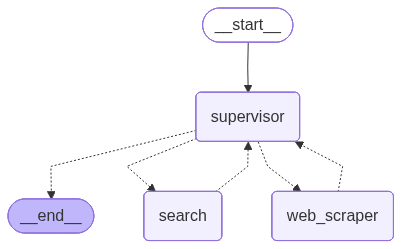

In [16]:
research_builder = StateGraph(State)

# Add Nodes
research_builder.add_node(node="supervisor", action=research_supervisor_node)
research_builder.add_node(node="search", action=search_node)
research_builder.add_node(node="web_scraper", action=web_scraper_node)

# Add Edges
research_builder.add_edge(start_key=START, end_key="supervisor")

# Compile Graph
research_graph = research_builder.compile()

research_graph

## Create Document Team

### Document Writing Node

In [17]:
doc_writer_agent = create_react_agent(
    model=llm,
    tools=[write_document, edit_document, read_document],
    prompt=(
        "You can read, write and edit documents based on note-taker's outlines. "
        "Don't ask follow-up questions."
    ),
)

def doc_writing_node(state: State) -> Command[Literal["supervisor"]]:
    result = doc_writer_agent.invoke(input=state)
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="doc_writer")
            ]
        },
        goto="supervisor",
    )

### Create Note Taking Node

In [18]:
note_taking_agent = create_react_agent(
    model=llm,
    tools=[create_outline, read_document],
    prompt=(
        "You can read documents and create outlines for the document writer. "
        "Don't ask follow-up questions."
    ),
)

def note_taking_node(state: State) -> Command[Literal["supervisor"]]:
    result = note_taking_agent.invoke(input=state)
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="note_taker")
            ]
        },
        goto="supervisor",
    )

### Create Chart Generator Node

In [19]:
chart_generating_agent = create_react_agent(
    model=llm, tools=[read_document, python_repl_tool]
)

def chart_generating_node(state: State) -> Command[Literal["supervisor"]]:
    result = chart_generating_agent.invoke(input=state)
    return Command(
        update={
            "messages": [
                HumanMessage(
                    content=result["messages"][-1].content, name="chart_generator"
                )
            ]
        },
        goto="supervisor",
    )

### Build Document Team Graph

In [20]:
document_supervisor_node = make_supervisor_node(
    llm=llm, members=["doc_writer", "note_taker", "chart_generator"]
)

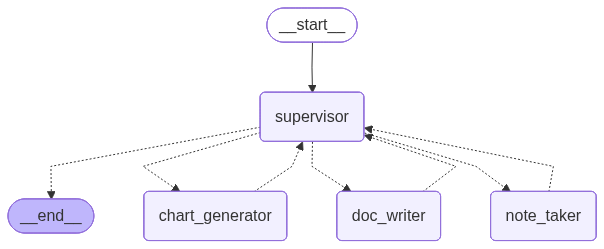

In [21]:
document_builder = StateGraph(State)

# Add Nodes
document_builder.add_node(node="supervisor", action=document_supervisor_node)
document_builder.add_node(node="doc_writer", action=doc_writing_node)
document_builder.add_node(node="note_taker", action=note_taking_node)
document_builder.add_node(node="chart_generator", action=chart_generating_node)

# Add Edges
document_builder.add_edge(start_key=START, end_key="supervisor")

# Compile Graph
document_graph = document_builder.compile()

document_graph

## Create Team Supervisor Node

In [22]:
teams_supervisor_node = make_supervisor_node(
    llm=llm, members=["research_team", "document_team"]
)

In [23]:
def call_research_team(state: State) -> Command[Literal["supervisor"]]:
    response = research_graph.invoke({"messages": state["messages"][-1]})
    return Command(
        update={
            "messages": [
                HumanMessage(
                    content=response["messages"][-1].content, name="research_team"
                )
            ]
        },
        goto="supervisor",
    )


def call_document_team(state: State) -> Command[Literal["supervisor"]]:
    response = document_graph.invoke({"messages": state["messages"][-1]})
    return Command(
        update={
            "messages": [
                HumanMessage(
                    content=response["messages"][-1].content, name="document_team"
                )
            ]
        },
        goto="supervisor",
    )

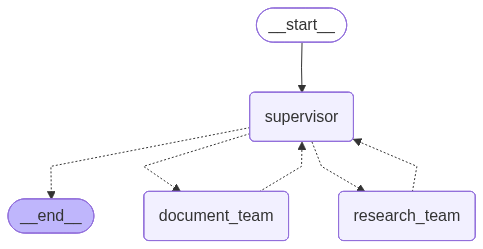

In [24]:
super_builder = StateGraph(State)

# Add Nodes
super_builder.add_node(node="supervisor", action=teams_supervisor_node)
super_builder.add_node(node="research_team", action=call_research_team)
super_builder.add_node(node="document_team", action=call_document_team)

# Add Edges
super_builder.add_edge(start_key=START, end_key="supervisor")

# Compile Graph
super_graph = super_builder.compile()
super_graph

## Query Graph

In [25]:
response = super_graph.invoke(
    {
        "messages": [
            ("user", "Write about transformer variants in production deployments.")
        ],
    }
)

In [26]:
response

{'messages': [HumanMessage(content='Write about transformer variants in production deployments.', additional_kwargs={}, response_metadata={}, id='17b9e678-e585-48f1-8a7b-36e788baa375'),
  HumanMessage(content='Transformer variants have significantly influenced the landscape of machine learning and natural language processing (NLP). Here are some prominent variants and considerations in their production deployments based on the insights gathered:\n\n### 1. **BERT (Bidirectional Encoder Representations from Transformers)**\n   - **Overview**: BERT excels in understanding the context of words and phrases in language, making it suitable for various NLP tasks such as question answering and sentiment analysis.\n   - **Challenges**: Its large size and computational demands can lead to latency issues, particularly in real-time applications.\n\n### 2. **GPT (Generative Pre-trained Transformer)**\n   - **Overview**: GPT models are optimized for text generation tasks, enabling capabilities like c

In [27]:
response["messages"][-1].content

'Great! If you need any further assistance with the document or would like to expand on any sections, feel free to let me know!'